## Data Extraction, Wrangling, and Pre-processing

In [153]:
pip install pandas requests sqlalchemy psycopg2 joblib scikit-learn fastapi uvicorn streamlit plotly seaborn matplotlib

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement hbdscan (from versions: none)
ERROR: No matching distribution found for hbdscan


In [8]:
import requests
import pandas as pd
import os
import time

# Define updated World Bank indicators and corresponding labels
wb_indicators = {
    "SP.POP.TOTL": "Total Population",
    "NY.GDP.PCAP.CD": "gdp_per_capita",
    "SL.UEM.TOTL.ZS": "unemployment_total",
    "FP.CPI.TOTL.ZG": "inflation",
    "SI.POV.DDAY": "poverty_rate",
    "SI.POV.GINI": "gini_index",
    "AG.PRD.FOOD.XD": "food_production_index",
    "AG.YLD.CREL.KG": "cereal_yield",
    "SL.UEM.1524.ZS": "youth_unemployment",
    "MS.MIL.XPND.GD.ZS": "military_expenditure"
}

# Define countries and year range
countries = "UKR;EGY;IRN;IRQ;ISR;JOR;LBN;SAU;SYR;TUR;ARE;YEM;KEN;NGA;ZAF;ETH;UGA;TZA;SDN;USA"
year_range = "2000:2023"

def fetch_worldbank_data(indicator, indicator_name):
    """
    Fetches World Bank data for a specific indicator and saves it to CSV.
    
    Parameters:
        indicator (str): World Bank indicator code.
        indicator_name (str): Name of the indicator for CSV filename.
    """
    WB_URL = f"http://api.worldbank.org/v2/country/{countries}/indicator/{indicator}?format=json&date={year_range}"
    all_data = []
    page = 1  # Start from the first page

    while True:
        print(f"Fetching {indicator_name} - Page {page}...")

        try:
            response = requests.get(f"{WB_URL}&page={page}", timeout=10).json()
        except Exception as e:
            print(f"Error fetching page {page} for {indicator_name}: {e}")
            break

        if len(response) < 2 or "message" in response:
            print(f"No more data available or error encountered for {indicator_name}.")
            break

        data = response[1]

        if not data:
            break

        # Append cleaned records
        all_data.extend([
            {
                "country": d["country"]["value"],
                "iso3": d["countryiso3code"],
                "year": int(d["date"]),
                indicator_name: d["value"]
            }
            for d in data if d["value"] is not None
        ])

        total_pages = response[0].get("pages", 1)
        if page >= total_pages:
            break
        page += 1
        time.sleep(0.3)  # Gentle pacing

    # Save to CSV
    df = pd.DataFrame(all_data)
    file_path = f"data/worldbank_{indicator_name}.csv"
    df.to_csv(file_path, na_rep="NULL", index=False)
    print(f"✅ {indicator_name} data saved to {file_path}!")

# Run the function for all indicators
for indicator, label in wb_indicators.items():
    fetch_worldbank_data(indicator, label)


Fetching gdp_per_capita - Page 1...
Fetching gdp_per_capita - Page 2...
Fetching gdp_per_capita - Page 3...
Fetching gdp_per_capita - Page 4...
Fetching gdp_per_capita - Page 5...
Fetching gdp_per_capita - Page 6...
Fetching gdp_per_capita - Page 7...
Fetching gdp_per_capita - Page 8...
Fetching gdp_per_capita - Page 9...
Fetching gdp_per_capita - Page 10...
✅ gdp_per_capita data saved to data/worldbank_gdp_per_capita.csv!
Fetching unemployment_total - Page 1...
Fetching unemployment_total - Page 2...
Fetching unemployment_total - Page 3...
Fetching unemployment_total - Page 4...
Fetching unemployment_total - Page 5...
Fetching unemployment_total - Page 6...
Fetching unemployment_total - Page 7...
Fetching unemployment_total - Page 8...
Fetching unemployment_total - Page 9...
Fetching unemployment_total - Page 10...
✅ unemployment_total data saved to data/worldbank_unemployment_total.csv!
Fetching inflation - Page 1...
Fetching inflation - Page 2...
Fetching inflation - Page 3...
Fetch

In [9]:
# List of countries with their coordinates (now includes USA)
countries = [
    ("Ukraine", 31.1656, 48.3794),
    ("Egypt", 30.8025, 26.8206),
    ("Iran", 53.6880, 32.4279),
    ("Iraq", 43.6793, 33.2232),
    ("Israel", 35.2137, 31.0461),
    ("Jordan", 36.2384, 30.5852),
    ("Lebanon", 35.8623, 33.8547),
    ("Saudi Arabia", 45.0792, 23.8859),
    ("Syria", 38.9968, 34.8021),
    ("Turkey", 35.2433, 38.9637),
    ("United Arab Emirates", 53.8478, 23.4241),
    ("Yemen", 48.5164, 15.5527),
    ("Kenya", 37.9062, -1.2921),
    ("Nigeria", 8.6753, 9.0820),
    ("South Africa", 25.1741, -30.5595),
    ("Ethiopia", 39.7823, 9.1450),
    ("Uganda", 32.2903, 1.3733),
    ("Tanzania", 34.8888, -6.3690),
    ("Sudan", 30.2176, 12.8628),
    ("United States", -98.5795, 39.8283)  # Central USA coords
]

# NASA POWER parameters related to conflict risk
nasa_parameters = [
    "T2M",             # Average air temperature at 2m (°C)
    "T2M_MAX",         # Max daily temperature
    "T2M_MIN",         # Min daily temperature
    "PRECTOTCORR",     # Precipitation (mm/day)
    "QV2M",            # Specific humidity at 2m
    "RH2M",            # Relative humidity at 2m
    "WS10M",           # Wind speed at 10m
    "ALLSKY_SFC_SW_DWN",  # Solar radiation at surface
]

# Initialize empty DataFrame list
all_weather_data = []

# Loop through countries
for country, lon, lat in countries:
    print(f"Fetching weather data for {country}...")

    nasa_url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    params = {
        "parameters": ",".join(nasa_parameters),
        "community": "RE",
        "longitude": lon,
        "latitude": lat,
        "start": "2000",
        "end": "2023",
        "format": "JSON"
    }

    try:
        response = requests.get(nasa_url, params=params, timeout=30)
        response.raise_for_status()  # HTTP error check
        weather_json = response.json()

        # Parse data
        df_dict = weather_json["properties"]["parameter"]
        df = pd.DataFrame(df_dict)
        df.index.name = "date"
        df.reset_index(inplace=True)
        df["year"] = df["date"].str[:4]
        df["country"] = country

        all_weather_data.append(df)
    except Exception as e:
        print(f"Unexpected error for {country}: {e}")

# Combine all DataFrames into one
final_weather_df = pd.concat(all_weather_data, ignore_index=True)

# Ensure 'year' column is numeric
final_weather_df["year"] = pd.to_numeric(final_weather_df["year"], errors="coerce")

# Group by country and year, then compute the mean
yearly_average_df = final_weather_df.groupby(["country", "year"]).mean(numeric_only=True).reset_index()




Fetching weather data for Ukraine...
Fetching weather data for Egypt...
Fetching weather data for Iran...
Fetching weather data for Iraq...
Fetching weather data for Israel...
Fetching weather data for Jordan...
Fetching weather data for Lebanon...
Fetching weather data for Saudi Arabia...
Fetching weather data for Syria...
Fetching weather data for Turkey...
Fetching weather data for United Arab Emirates...
Fetching weather data for Yemen...
Fetching weather data for Kenya...
Fetching weather data for Nigeria...
Fetching weather data for South Africa...
Fetching weather data for Ethiopia...
Fetching weather data for Uganda...
Fetching weather data for Tanzania...
Fetching weather data for Sudan...
Fetching weather data for United States...


In [17]:
yearly_average_df.to_csv(r'data\yearly_weather_average.csv', na_rep="NULL", index=False)

<>:1: SyntaxWarning: invalid escape sequence '\y'
<>:1: SyntaxWarning: invalid escape sequence '\y'
C:\Users\7tige\AppData\Local\Temp\ipykernel_33856\3016105654.py:1: SyntaxWarning: invalid escape sequence '\y'
  yearly_average_df.to_csv('data\yearly_weather_average.csv', na_rep="NULL", index=False)


In [34]:
# ACLED API URL
ACLED_URL = "https://api.acleddata.com/acled/read"

# Your ACLED credentials
API_KEY = "F*jsJ3FcWLMHtZkq0CMe"
EMAIL = "ahk2190@columbia.edu"

# List of countries
countries = [
    "Ukraine", "Egypt", "Iran", "Iraq", "Israel", "Jordan", "Lebanon",
    "Saudi Arabia", "Syria", "Turkey", "United Arab Emirates", "Yemen",
    "Kenya", "Nigeria", "South Africa", "Ethiopia", "Uganda", "Tanzania", "Sudan", "United States"
]

headers = {
    "User-Agent": "Mozilla/5.0"
}

# Collect all data
all_conflict_data = []

for country in countries:
    print(f" Fetching all conflict events for {country} (2000–2023)...")

    params = {
        "email": EMAIL,
        "key": API_KEY,
        "country": country,
        "start_date": "2000-01-01",
        "end_date": "2023-12-31",
    }

    try:
        response = requests.get(ACLED_URL, params=params, headers=headers)
        response.raise_for_status()
        data = response.json().get("data", [])

        if data:
            all_conflict_data.extend(data)
        else:
            print(f" No data found for {country}.")

        time.sleep(2)

    except Exception as e:
        print(f" Error fetching data for {country}: {e}")

df_conflict = pd.DataFrame(all_conflict_data)

 Fetching all conflict events for Ukraine (2000–2023)...
 Fetching all conflict events for Egypt (2000–2023)...
 Fetching all conflict events for Iran (2000–2023)...
 Fetching all conflict events for Iraq (2000–2023)...
 Fetching all conflict events for Israel (2000–2023)...
 Fetching all conflict events for Jordan (2000–2023)...
 Fetching all conflict events for Lebanon (2000–2023)...
 Fetching all conflict events for Saudi Arabia (2000–2023)...
 Fetching all conflict events for Syria (2000–2023)...
 Fetching all conflict events for Turkey (2000–2023)...
 Fetching all conflict events for United Arab Emirates (2000–2023)...
 Fetching all conflict events for Yemen (2000–2023)...
 Fetching all conflict events for Kenya (2000–2023)...
 Fetching all conflict events for Nigeria (2000–2023)...
 Fetching all conflict events for South Africa (2000–2023)...
 Fetching all conflict events for Ethiopia (2000–2023)...
 Fetching all conflict events for Uganda (2000–2023)...
 Fetching all conflict ev

In [39]:
# Ensure date and numeric types are correct
df_conflict["event_date"] = pd.to_datetime(df_conflict["event_date"], errors="coerce")
df_conflict["year"] = df_conflict["event_date"].dt.year
df_conflict["fatalities"] = pd.to_numeric(df_conflict["fatalities"], errors="coerce").fillna(0)

# Only keep relevant disorder types
valid_types = ["Demonstrations", "Strategic developments", "Political violence"]
df_conflict = df_conflict[df_conflict["disorder_type"].isin(valid_types)]

# Group by country, year, and disorder_type for event counts
event_counts = (
    df_conflict.groupby(["country", "year", "disorder_type"])
    .size()
    .reset_index(name="event_count")
)

# Group by country and year for total fatalities
fatalities = (
    df_conflict.groupby(["country", "year"])["fatalities"]
    .sum()
    .reset_index(name="total_fatalities")
)

# Pivot disorder types to columns
event_counts_pivot = event_counts.pivot_table(
    index=["country", "year"],
    columns="disorder_type",
    values="event_count",
    fill_value=0
).reset_index()

# Merge with fatalities
summary_df = event_counts_pivot.merge(fatalities, on=["country", "year"])

# Optional: Save to CSV
summary_df.to_csv(r"data\acled_disorder_summary_by_country_year.csv", index=False)

In [283]:
import glob
country_name_mapping = {
    "Syrian Arab Republic": "Syria",
    "Egypt, Arab Rep.": "Egypt",
    "Iran, Islamic Rep.": "Iran",
    "Yemen, Rep.": "Yemen",    
    "Turkiye": "Turkey"
    # Add more mappings as needed
}

# Step 1: Load all relevant CSVs
file_paths = glob.glob("data/*.csv")
dfs = []

for file_path in file_paths:
    df = pd.read_csv(file_path, na_values="NULL")

    # Ensure 'country' and 'year' columns exist
    if 'country' in df.columns and 'year' in df.columns:
        # Normalize country names using mapping
        df["country"] = df["country"].replace(country_name_mapping)
        df["country"] = df["country"].str.strip()  # Remove extra whitespace

        # Prefix value columns with filename
        name = os.path.splitext(os.path.basename(file_path))[0].replace("worldbank_", "")
        value_cols = [col for col in df.columns if col not in ['country', 'year']]
        df.rename(columns={col: f"{name}_{col}" for col in value_cols}, inplace=True)

        dfs.append(df)
    else:
        print(f"Skipping file (missing 'country' or 'year'): {file_path}")

# Step 2: Outer merge on 'country' and 'year'
from functools import reduce
merged_df = reduce(lambda left, right: pd.merge(left, right, on=["country", "year"], how="outer"), dfs)

# Step 3: Optional cleanup
merged_df.sort_values(by=["country", "year"], inplace=True)

# Step 4: Export final dataset (optional: keep NaNs or cast to string)
merged_df.to_csv("data/mega_dataset.csv", index=False)

Skipping file (missing 'country' or 'year'): data\acled_summary_by_year.csv


In [285]:
#clean data and delete redundant or unvaluable columns
columns_to_keep = [
    "country", "year",
    "cereal_yield_cereal_yield",
    "food_production_index_food_production_index",
    "gdp_per_capita_gdp_per_capita",
    "gini_index_gini_index",
    "Inflation_inflation",
    "military_expenditure_military_expenditure",
    "poverty_rate_poverty_rate",
    "unemployment_total_unemployment_total",
    "youth_unemployment_youth_unemployment",
    "yearly_weather_average_T2M",
    "yearly_weather_average_T2M_MAX",
    "yearly_weather_average_T2M_MIN",
    "yearly_weather_average_PRECTOTCORR",
    "yearly_weather_average_QV2M",
    "yearly_weather_average_RH2M",
    "yearly_weather_average_WS10M",
    "yearly_weather_average_ALLSKY_SFC_SW_DWN",
    "acled_disorder_summary_by_country_year_Demonstrations",
    "acled_disorder_summary_by_country_year_Political violence",
    "acled_disorder_summary_by_country_year_Strategic developments",
    "acled_disorder_summary_by_country_year_total_fatalities"
]

# Filter and drop rows with all null values in the indicators
merged_df_clean = merged_df[columns_to_keep].dropna(how="all", subset=columns_to_keep[2:])

# Drop duplicate country-year combinations if they exist
final_df = merged_df_clean.drop_duplicates(subset=["country", "year"])
final_df.to_csv(r"data\final_dataset.csv", index = False)



## Feature Engineering

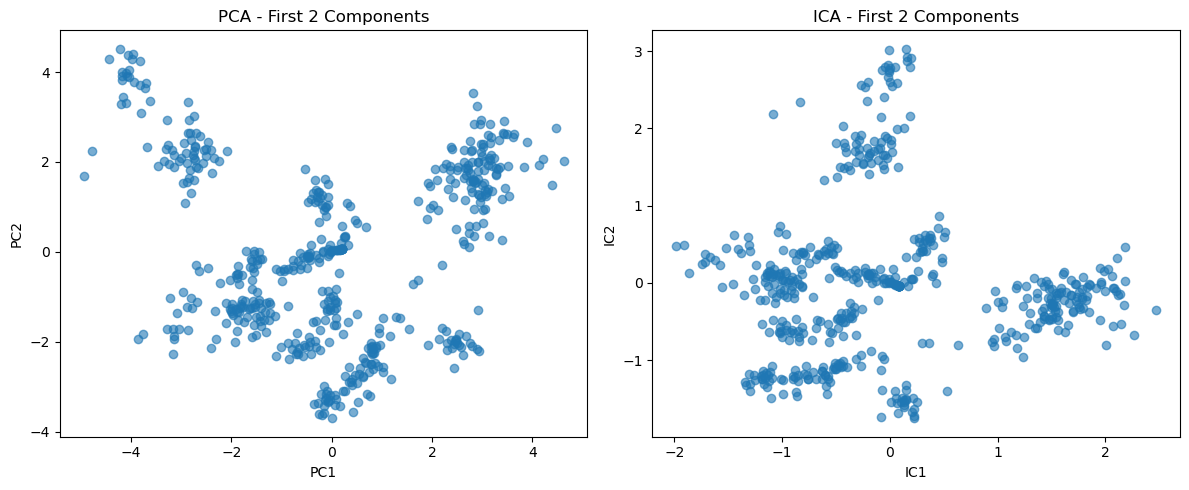

C:\Users\7tige\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\7tige\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\7tige\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\7tige\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

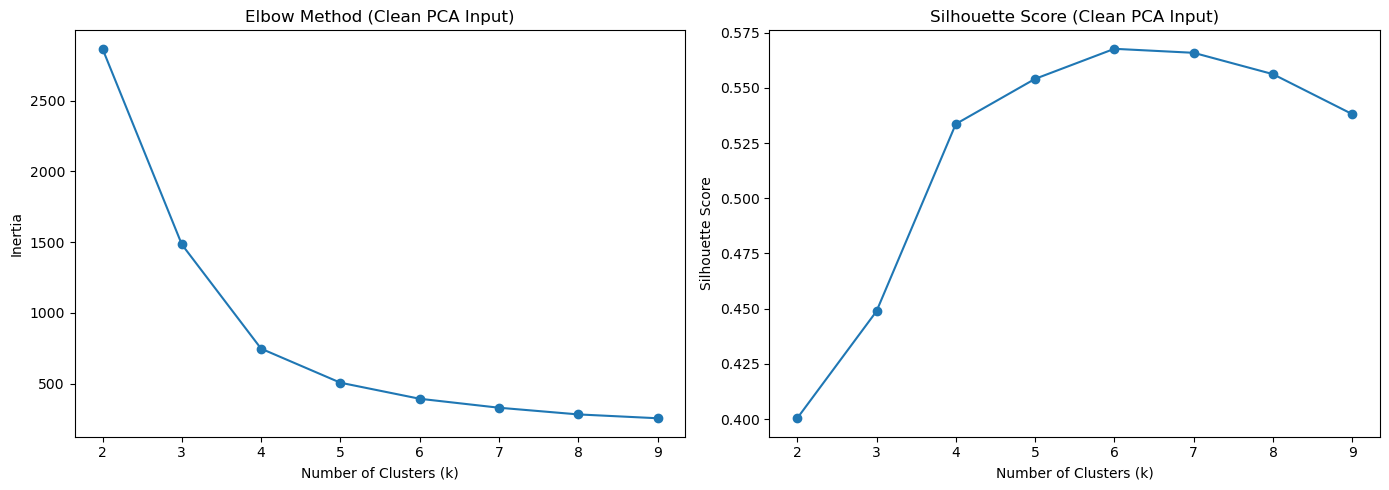

In [237]:
# Apply Elbow Method to PCA result from final_df (excluding conflict labels)
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Prepare data for PCA/ICA: exclude non-numeric columns
features = final_df.drop(columns=["country", "year"])
features_scaled = StandardScaler().fit_transform(features.fillna(features.mean()))

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)

# ICA
ica = FastICA(n_components=2, random_state=42)
ica_result = ica.fit_transform(features_scaled)

# Plot PCA
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6)
plt.title("PCA - First 2 Components")
plt.xlabel("PC1")
plt.ylabel("PC2")

# Plot ICA
plt.subplot(1, 2, 2)
plt.scatter(ica_result[:, 0], ica_result[:, 1], alpha=0.6)
plt.title("ICA - First 2 Components")
plt.xlabel("IC1")
plt.ylabel("IC2")

plt.tight_layout()
plt.show()
# Standardize and reduce via PCA (already done above)
# We'll now compute inertia for various k-values using PCA result
inertia_vals_clean = []
silhouette_vals_clean = []
k_range_clean = range(2, 10)

for k in k_range_clean:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_result)
    inertia_vals_clean.append(kmeans.inertia_)
    silhouette_vals_clean.append(silhouette_score(pca_result, kmeans.labels_))

# Plot elbow and silhouette scores
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].plot(k_range_clean, inertia_vals_clean, marker='o')
ax[0].set_title("Elbow Method (Clean PCA Input)")
ax[0].set_xlabel("Number of Clusters (k)")
ax[0].set_ylabel("Inertia")

ax[1].plot(k_range_clean, silhouette_vals_clean, marker='o')
ax[1].set_title("Silhouette Score (Clean PCA Input)")
ax[1].set_xlabel("Number of Clusters (k)")
ax[1].set_ylabel("Silhouette Score")

plt.tight_layout()
plt.show()


## Clustering

C:\Users\7tige\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


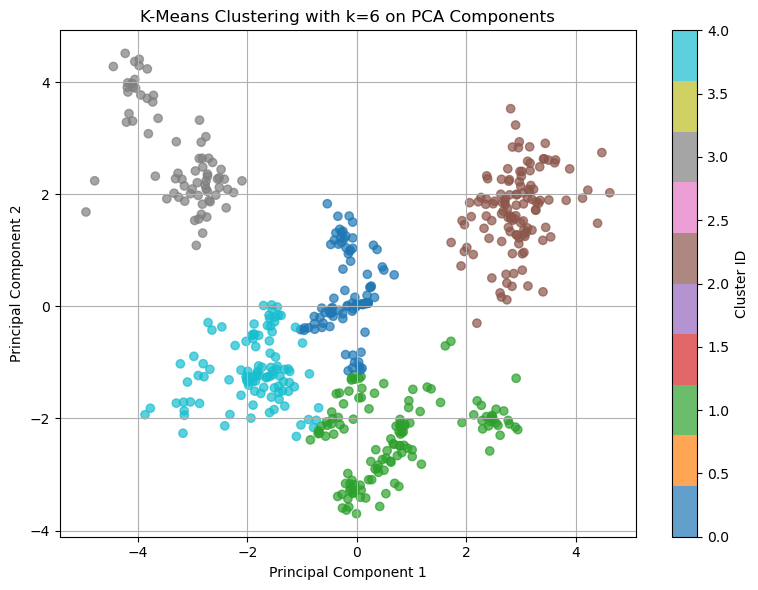

C:\Users\7tige\AppData\Local\Temp\ipykernel_33856\3996894922.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["dbscan_cluster"] = dbscan_labels


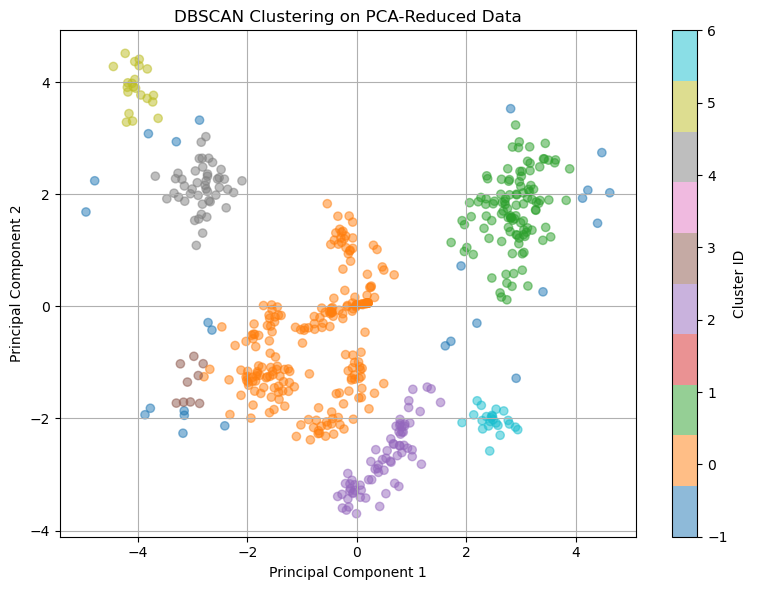

C:\Users\7tige\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


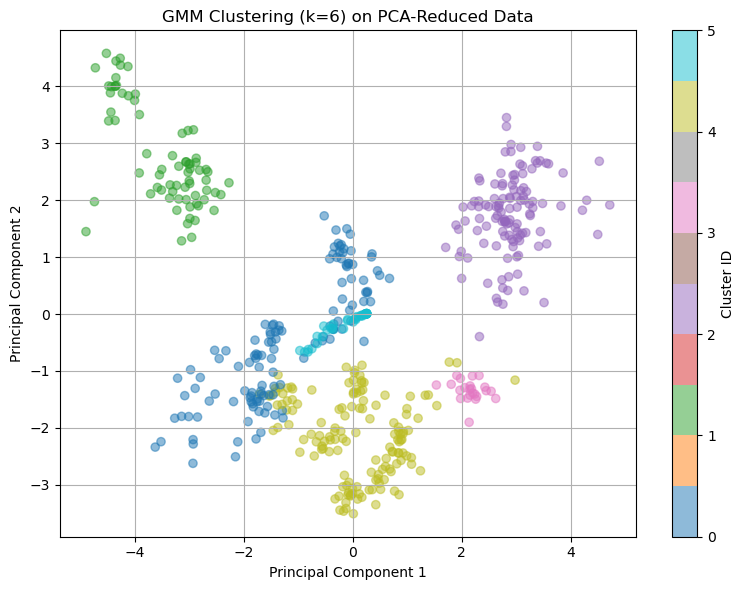

In [243]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN

# Apply KMeans clustering with k=5 to PCA result
kmeans_6 = KMeans(n_clusters=6, random_state=42)
cluster_labels = kmeans_5.fit_predict(pca_result)

# Create a scatter plot with clusters visualized
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='tab10', alpha=0.7)
plt.title("K-Means Clustering with k=6 on PCA Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(scatter, label="Cluster ID")
plt.grid(True)
plt.tight_layout()
plt.show()

# Apply DBSCAN clustering to PCA-reduced data
dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(pca_result)

# Add DBSCAN labels to final_df
final_df["dbscan_cluster"] = dbscan_labels

# Plot DBSCAN clusters
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=dbscan_labels, cmap="tab10", alpha=.5)
plt.title("DBSCAN Clustering on PCA-Reduced Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster ID")
plt.grid(True)
plt.tight_layout()
plt.show()


# Apply GMM clustering 

# Drop non-numeric columns and handle missing values
X = final_df.drop(columns=["country", "year"], errors="ignore")
X_imputed = X.fillna(X.mean())  # Fill NaNs with mean

# Scale the data
X_scaled = StandardScaler().fit_transform(X_imputed)

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Fit GMM on scaled, imputed data
gmm = GaussianMixture(n_components=6, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)

# Assign labels and plot
final_df_gmm = final_df.copy()
final_df_gmm["gmm_cluster"] = gmm_labels

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, cmap="tab10", alpha=0.5)
plt.title("GMM Clustering (k=6) on PCA-Reduced Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster ID")
plt.grid(True)
plt.tight_layout()
plt.show()

## Unsupervised Classification

In [251]:
final_df = final_df.copy()  # ensures it's not a view
# Assign to DataFrame
final_df["kmeans_cluster"] = cluster_labels
# Assign to DataFrame
final_df["dbscan_cluster"] = dbscan_labels
# Assign to DataFrame
final_df["gmm_cluster"] = gmm_labels
final_df.to_csv(r"data\final_df_w_clusters.csv", index = False)


In [256]:
gmm_labels = {
    0: "Fragile or unstable states",
    1: "Economically poor but politically quiet",
    2: "Transitional middle-income states",
    3: "Active conflict zones",
    4: "Stable and developed countries",
    5: "Volatile states with fluctuating conditions"
}
final_df["gmm_profile"] = final_df["gmm_cluster"].map(gmm_labels)

kmeans_labels = {
    0: "Stable and developed countries",
    1: "Fragile but low-violence",
    2: "Rising unrest with economic distress",
    3: "Active conflict zones",
    4: "Transitional economies under pressure",
    5: "Volatile youth-driven discontent"
}
final_df["kmeans_profile"] = final_df["kmeans_cluster"].map(kmeans_labels)

dbscan_labels = {
    -1: "Noise / Unclassified",
     0: "Core conflict zone",
     1: "Peripheral instability",
     2: "Stable cluster",
     3: "High-fatality anomaly",
     4: "Climate-sensitive state",
     5: "Youth unrest core"
}
final_df["dbscan_profile"] = final_df["dbscan_cluster"].map(dbscan_labels)

final_df.to_csv(r"data\classification_df.csv", index = False)

C:\Users\7tige\AppData\Local\Temp\ipykernel_33856\600584487.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  encoded_transition = encoded_transition.applymap(


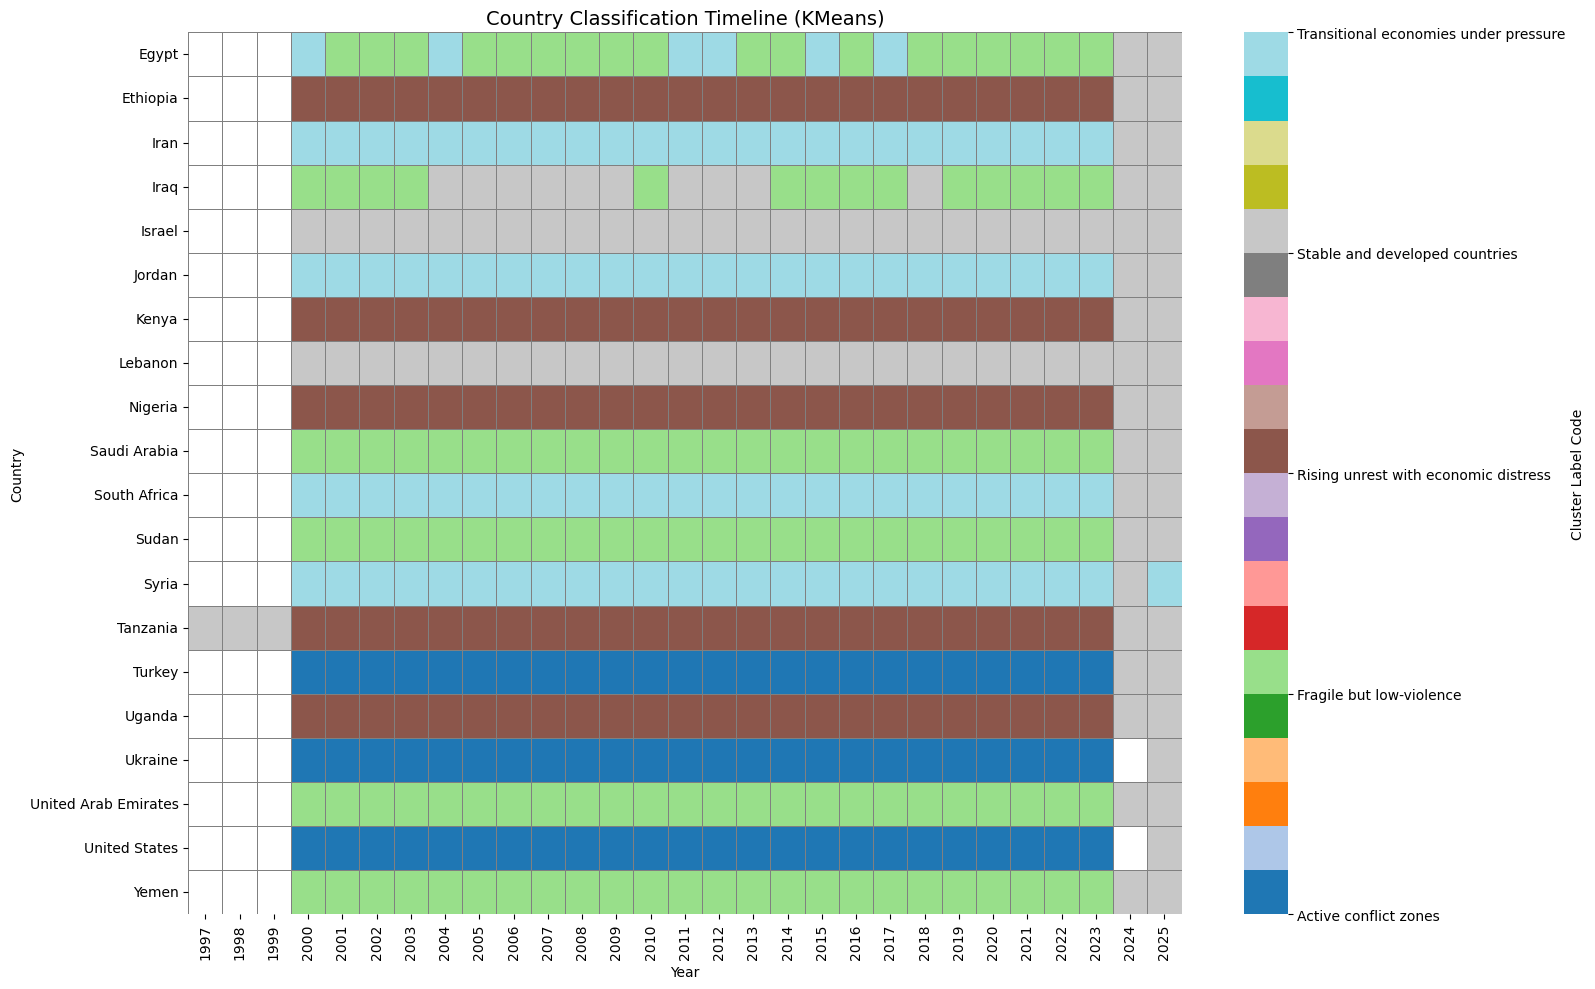

C:\Users\7tige\AppData\Local\Temp\ipykernel_33856\600584487.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  encoded_transition = encoded_transition.applymap(


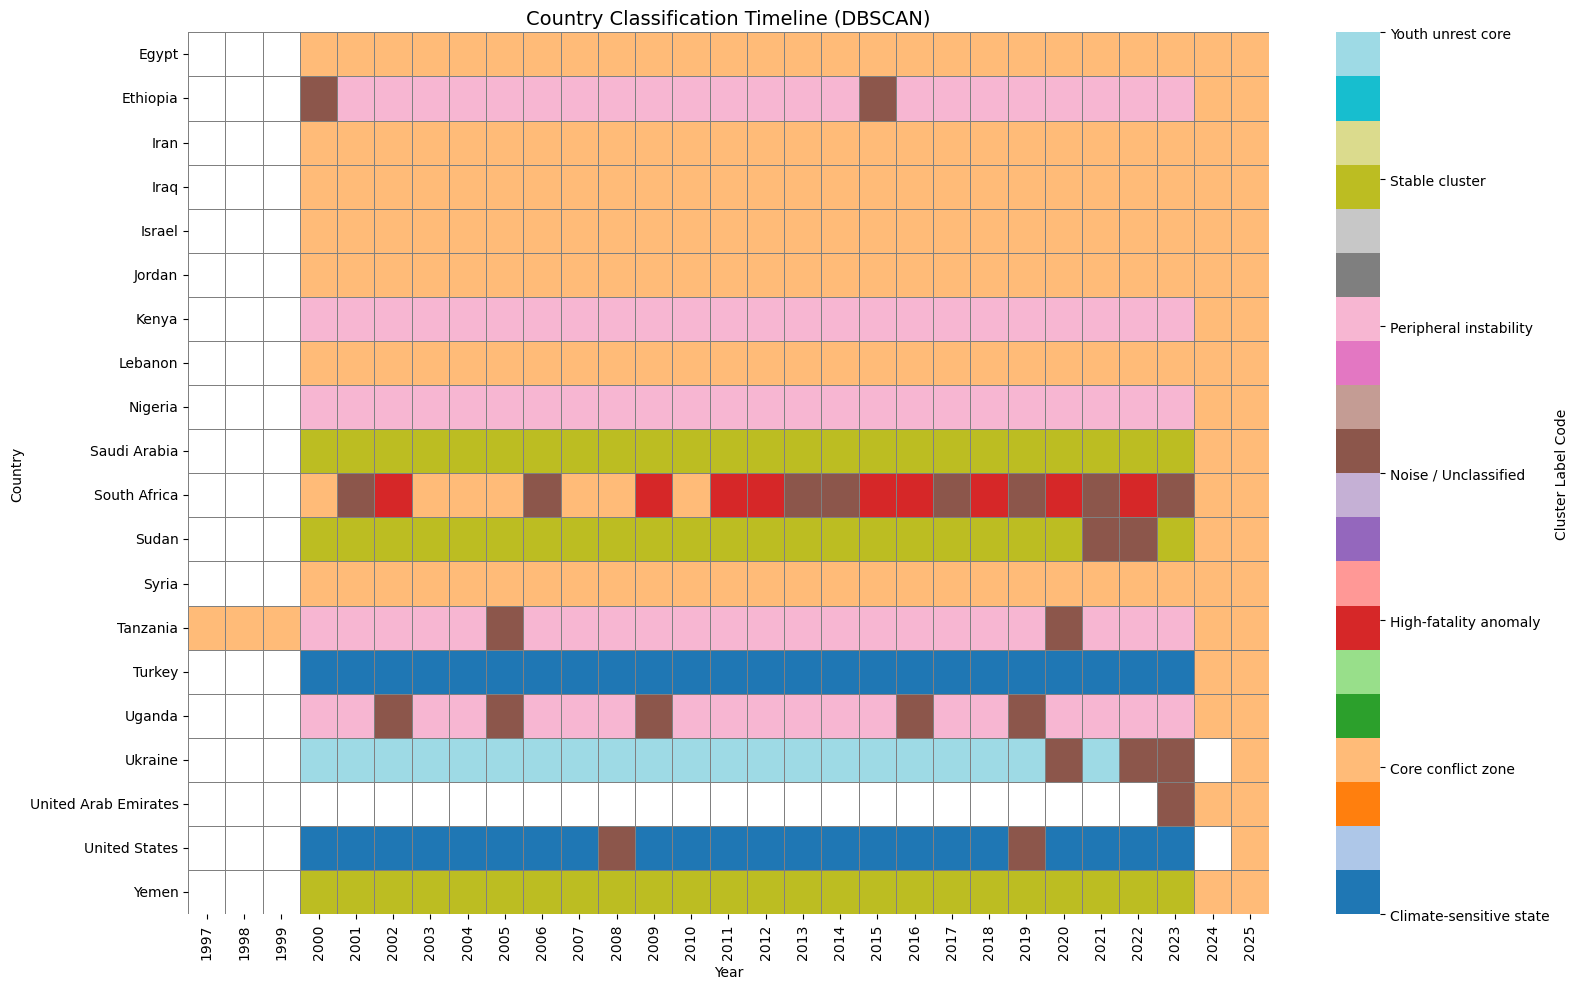

C:\Users\7tige\AppData\Local\Temp\ipykernel_33856\600584487.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  encoded_transition = encoded_transition.applymap(


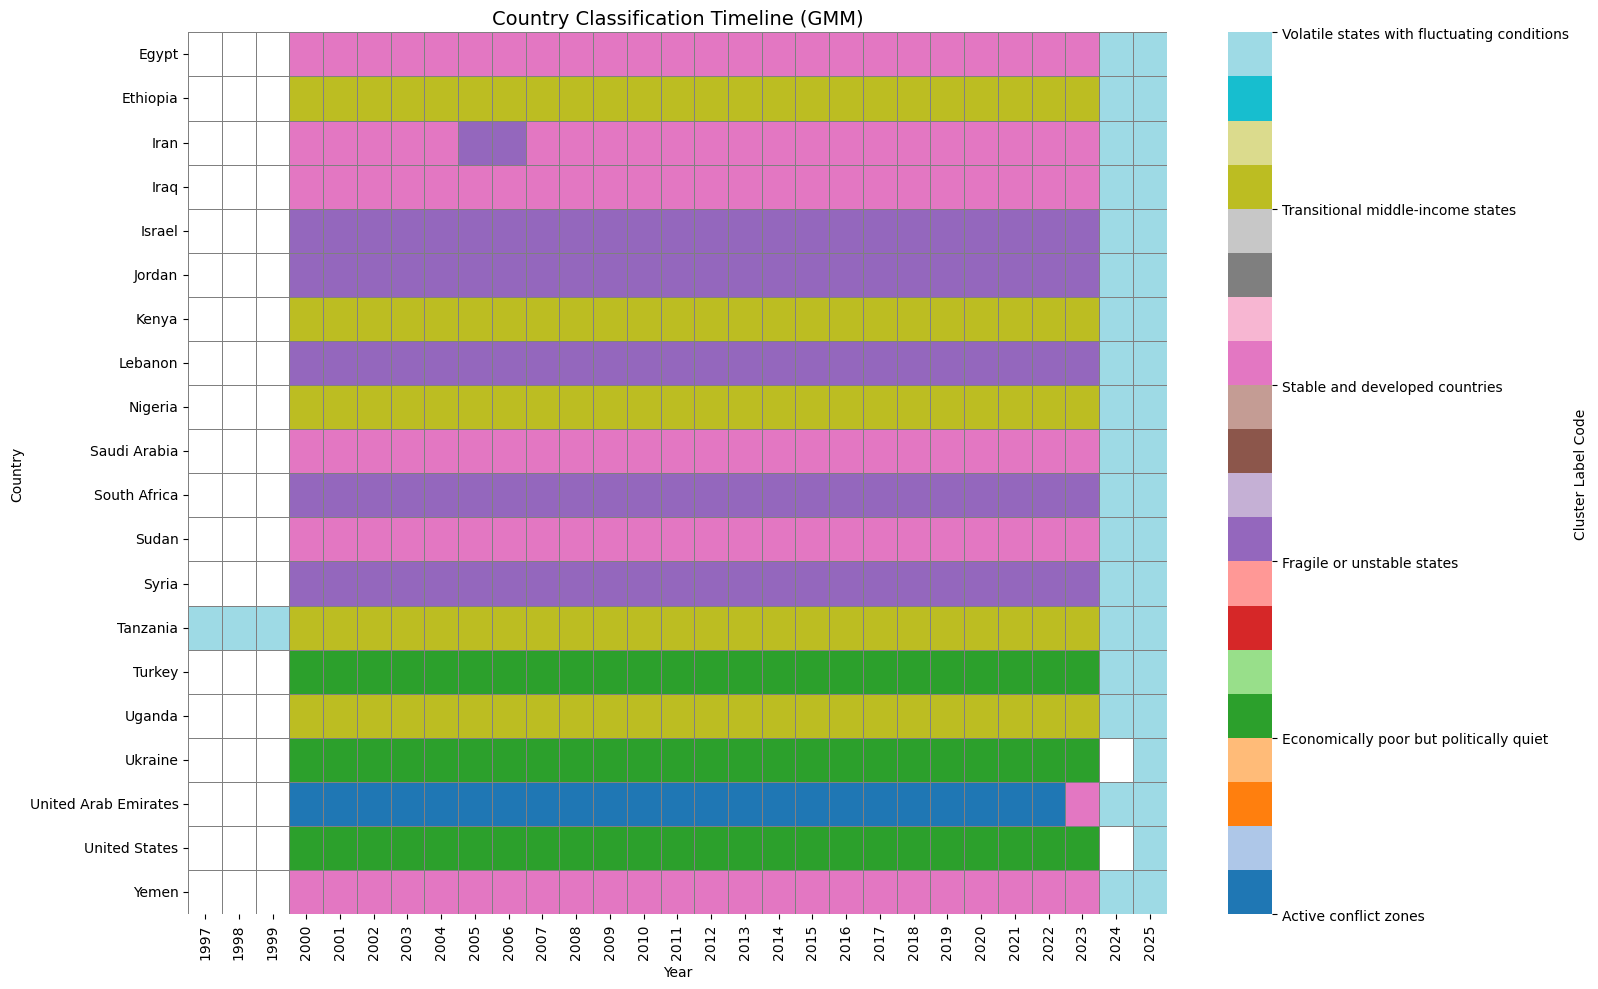

In [275]:
# Reassign gmm_profile with proper labels if it doesn't exist
if "gmm_profile" not in final_df.columns:
    gmm_labels = {
        0: "Fragile or unstable states",
        1: "Economically poor but politically quiet",
        2: "Transitional middle-income states",
        3: "Active conflict zones",
        4: "Stable and developed countries",
        5: "Volatile states with fluctuating conditions"
    }
    final_df["gmm_profile"] = final_df["gmm_cluster"].map(gmm_labels)

# Function to plot heatmap with legend for any profile column
def plot_cluster_profile_heatmap_with_legend(df, profile_column, title):
    transition_matrix = df.pivot_table(
        index="country",
        columns="year",
        values=profile_column,
        aggfunc="first"
    )

    # Encode to numeric codes
    encoded_transition = transition_matrix.copy()
    label_encoder = LabelEncoder()
    all_profiles = pd.Series(encoded_transition.values.ravel()).dropna().unique()
    label_encoder.fit(all_profiles)
    class_names = label_encoder.classes_

    encoded_transition = encoded_transition.applymap(
        lambda x: label_encoder.transform([x])[0] if pd.notnull(x) else np.nan
    )

    # Plot
    plt.figure(figsize=(16, 10))
    sns.heatmap(encoded_transition, cmap="tab20", linewidths=0.5, linecolor="gray",
                cbar_kws={'label': 'Cluster Label Code'}, square=False)
    plt.title(title, fontsize=14)
    plt.xlabel("Year")
    plt.ylabel("Country")

    # Add colorbar legend labels
    colorbar = plt.gcf().axes[-1]
    colorbar.set_yticks(range(len(class_names)))
    colorbar.set_yticklabels(class_names)

    plt.tight_layout()
    plt.show()

# Plot KMeans, GMM, and DBSCAN profiles (only if they exist)
plot_cluster_profile_heatmap_with_legend(final_df, "kmeans_profile", "Country Classification Timeline (KMeans)")
plot_cluster_profile_heatmap_with_legend(final_df, "dbscan_profile", "Country Classification Timeline (DBSCAN)")
plot_cluster_profile_heatmap_with_legend(final_df, "gmm_profile", "Country Classification Timeline (GMM)")

